<a href="https://colab.research.google.com/github/antahiap/dsr-image-dataset-curation/blob/main/picasso_scrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [38]:
import skimage.io as io
from PIL import Image
from pathlib import Path

img_array =io.imread("https://www.pacegallery.com/media/images/58925.width-2000.jpg")
img_array.shape

(2480, 2000, 3)

In [39]:
# image = Image.fromarray(img_array)
image

PosixPath('art_recommendation/paintings/picasso_397.jpg')

To get the accsess to the shared folder needs to add shared link to the MyDrive.

In [ ]:
! ls '/gdrive/MyDrive/art_recommendation/picasso_2'


paintings  urls.txt


In [40]:
my_path = '/gdrive/MyDrive/art_recommendation/picasso_2'
url_path = f'{my_path}/urls.txt'

with open(url_path, 'r')as file:
  image_urls = file.readlines()

In [ ]:
import os
# os.mkdir(f'{my_path}/paintings')

In [ ]:
from skimage.io.util import HTTPError

for index, url in enumerate(image_urls[1:]):
  try:
    image = Image.fromarray(io.imread(url)[:, :, :3])
    # image.save(my_path / 'paintings' / f'picasso_{index}.jpg')
    image.save(f'{my_path}/paintings/picasso_{index}.jpg')
    # break
  except(HTTPError, ValueError) as e: # it might be other errors, better to use the general ones
    print(f"{e}")
    continue

In [41]:
# https://github.com/christiansafka/img2vec
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048,
    }

    def __init__(self, cuda=False, model='resnet-34', layer='default',
                 layer_output_size=512):
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        self.device = torch.device("cuda" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image or list of PIL Images
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[:, :]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name == 'alexnet':
                my_embedding = torch.zeros(1, self.layer_output_size)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name == 'alexnet':
                    return my_embedding.numpy()[0, :]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-34':
            model = models.resnet34(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)




In [ ]:
img2vec = Img2Vec()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 85.6MB/s]


In [ ]:
img2vec.get_vec(image).shape

(512,)

In [44]:
my_path = Path(my_path)

In [77]:
paintings =  os.listdir(my_path / 'paintings')
key_prefix = Path(my_path.parent.stem) / 'picasso_2' / 'paintings'


paintings_embeddings ={}

for painting_path in paintings:
  img_path = my_path / 'paintings' / painting_path
  image = Image.open(img_path)
  vec = img2vec.get_vec(image)
  paintings_embeddings[key_prefix / painting_path] = vec


In [73]:
print(my_path)

/gdrive/MyDrive/art_recommendation/picasso_2


In [78]:
# check out the integrity of our pickle file
import pickle
with open(my_path / 'paintings_embeddings.pickle', 'wb') as handle:
    pickle.dump(paintings_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(my_path / 'paintings_embeddings.pickle', 'rb') as handle:
    b = pickle.load(handle)

assert len(b.keys()) == len(paintings_embeddings.keys())

In [67]:
len(b.keys())

319

In [ ]:
import matplotlib.pyplot as plt

def show_pair(imag_a, imag_b):
  plt.subplot(121)
  plt.imshow(np.array(imag_a))
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(np.array(imag_b))
  plt.axis("off")

In [ ]:
from numpy import dot
from numpy.linalg import norm

#https://stackoverflow.com/a/43043160/45963
def cosine_similarity(a, b):
  return dot(a, b)/(norm(a)*norm(b))

#https://stackoverflow.com/a/1401828/45963
def euclidean_distance(a, b):
  return norm(a-b)

0.66


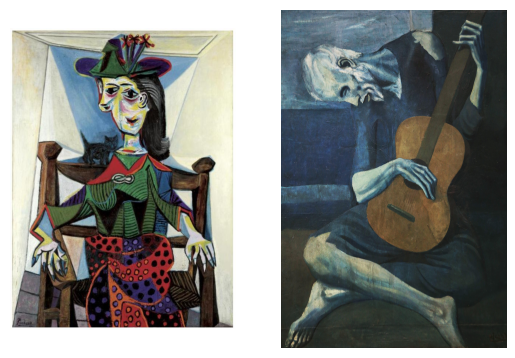

In [68]:
# @title Cosine similarity {run:'auto'}
# @markdown Forms support many types of fields.

slider_1 = 227  # @param {type: "slider", min: 0, max: 319}
slider_2 = 19  # @param {type: "slider", min: 0, max: 319}

constructed_path_1 =  my_path / 'paintings' / f'picasso_{slider_1}.jpg'
constructed_path_2 =  my_path / 'paintings' / f'picasso_{slider_2}.jpg'

img_1 = Image.open(constructed_path_1)
img_2 = Image.open(constructed_path_2)

vec_1 = list(paintings_embeddings.values())[slider_1]
vec_2 = list(paintings_embeddings.values())[slider_2]
print(f'{cosine_similarity(vec_1, vec_2):.2f}')

show_pair(img_1, img_2)

In [79]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# separate vectors and images (for convenience)
X = []
images = []
for image, embedding in paintings_embeddings.items():
    X.append(embedding)
    images.append(str(image))

# sklearn gives the cosine distance = 1 - cos_similarity
nbrs = NearestNeighbors(n_neighbors=9, metric='cosine').fit(X)
nbrs

NearestNeighbors(metric='cosine', n_neighbors=9)

In [80]:
neighbor_distances, neighbor_indices = nbrs.kneighbors(X)
neighbor_similarities = 1 - neighbor_distances

In [82]:
# check sklearn's cosine distance vs our own cosine similarity metric
from numpy.linalg import norm
def cosine_similarity(vector_a, vector_b):
    return np.inner(vector_a, vector_b) / (norm(vector_a) * norm(vector_b))


neighborhoods_dict = {}
for i in range(len(neighbor_indices)):
    center_image = images[neighbor_indices[i, 0]]
    neighbors_list = [];
    for j in range(0, len(neighbor_indices[0])):
        neighbor_image = images[neighbor_indices[i][j]]
        neighbor_similarity =  neighbor_similarities[i][j]
        neighbors_list.append([neighbor_image, neighbor_similarity])
    neighborhoods_dict[center_image] = neighbors_list

neighborhoods_dict['art_recommendation/picasso_2/paintings/picasso_145.jpg']

[['art_recommendation/picasso_2/paintings/picasso_145.jpg', 1.0],
 ['art_recommendation/picasso_2/paintings/picasso_133.jpg', 0.79472],
 ['art_recommendation/picasso_2/paintings/picasso_105.jpg', 0.7872771],
 ['art_recommendation/picasso_2/paintings/picasso_314.jpg', 0.7827228],
 ['art_recommendation/picasso_2/paintings/picasso_325.jpg', 0.77906185],
 ['art_recommendation/picasso_2/paintings/picasso_216.jpg', 0.7788623],
 ['art_recommendation/picasso_2/paintings/picasso_172.jpg', 0.77807176],
 ['art_recommendation/picasso_2/paintings/picasso_279.jpg', 0.77604145],
 ['art_recommendation/picasso_2/paintings/picasso_140.jpg', 0.7724943]]

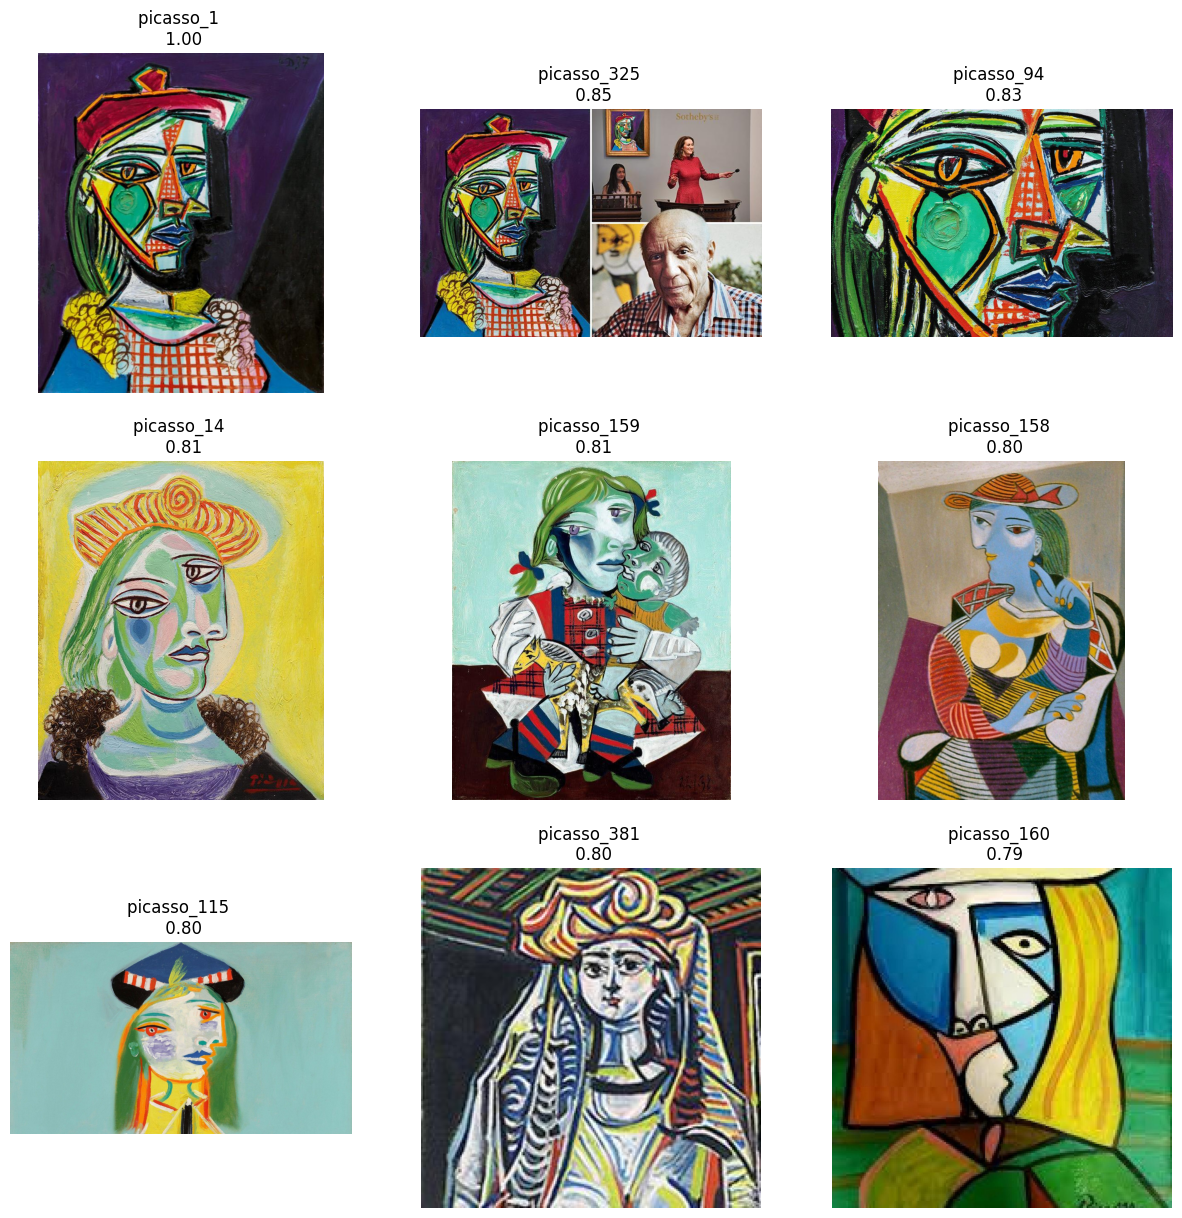

In [83]:
import skimage.io as io
import matplotlib.pyplot as plt


def plot_neighborhood(neighbors_row):
  f, axarr = plt.subplots(3,3, figsize=(15,15))
  #import pdb; pdb.set_trace(
  axarr[0][0].imshow(io.imread(my_path.parent.parent / neighbors_row[0][0]))
  axarr[0][1].imshow(io.imread(my_path.parent.parent / neighbors_row[1][0]))
  axarr[0][2].imshow(io.imread(my_path.parent.parent / neighbors_row[2][0]))
  axarr[1][0].imshow(io.imread(my_path.parent.parent / neighbors_row[3][0]))
  axarr[1][1].imshow(io.imread(my_path.parent.parent / neighbors_row[4][0]))
  axarr[1][2].imshow(io.imread(my_path.parent.parent / neighbors_row[5][0]))
  axarr[2][0].imshow(io.imread(my_path.parent.parent / neighbors_row[6][0]))
  axarr[2][1].imshow(io.imread(my_path.parent.parent / neighbors_row[7][0]))
  axarr[2][2].imshow(io.imread(my_path.parent.parent / neighbors_row[8][0]))
  axarr[0, 0].set_title(f'{Path(neighbors_row[0][0]).stem} \n {neighbors_row[0][1]:.2f}')
  axarr[0, 1].set_title(f'{Path(neighbors_row[1][0]).stem} \n {neighbors_row[1][1]:.2f}')
  axarr[0, 2].set_title(f'{Path(neighbors_row[2][0]).stem} \n {neighbors_row[2][1]:.2f}')
  axarr[1, 0].set_title(f'{Path(neighbors_row[3][0]).stem} \n {neighbors_row[3][1]:.2f}')
  axarr[1, 1].set_title(f'{Path(neighbors_row[4][0]).stem} \n {neighbors_row[4][1]:.2f}')
  axarr[1, 2].set_title(f'{Path(neighbors_row[5][0]).stem} \n {neighbors_row[5][1]:.2f}')
  axarr[2, 0].set_title(f'{Path(neighbors_row[6][0]).stem} \n {neighbors_row[6][1]:.2f}')
  axarr[2, 1].set_title(f'{Path(neighbors_row[7][0]).stem} \n {neighbors_row[7][1]:.2f}')
  axarr[2, 2].set_title(f'{Path(neighbors_row[8][0]).stem} \n {neighbors_row[8][1]:.2f}')

  for i in range(3):
        for j in range(3):
            axarr[i, j].axis('off')

plot_neighborhood(neighborhoods_dict[list(neighborhoods_dict.keys())[0]])

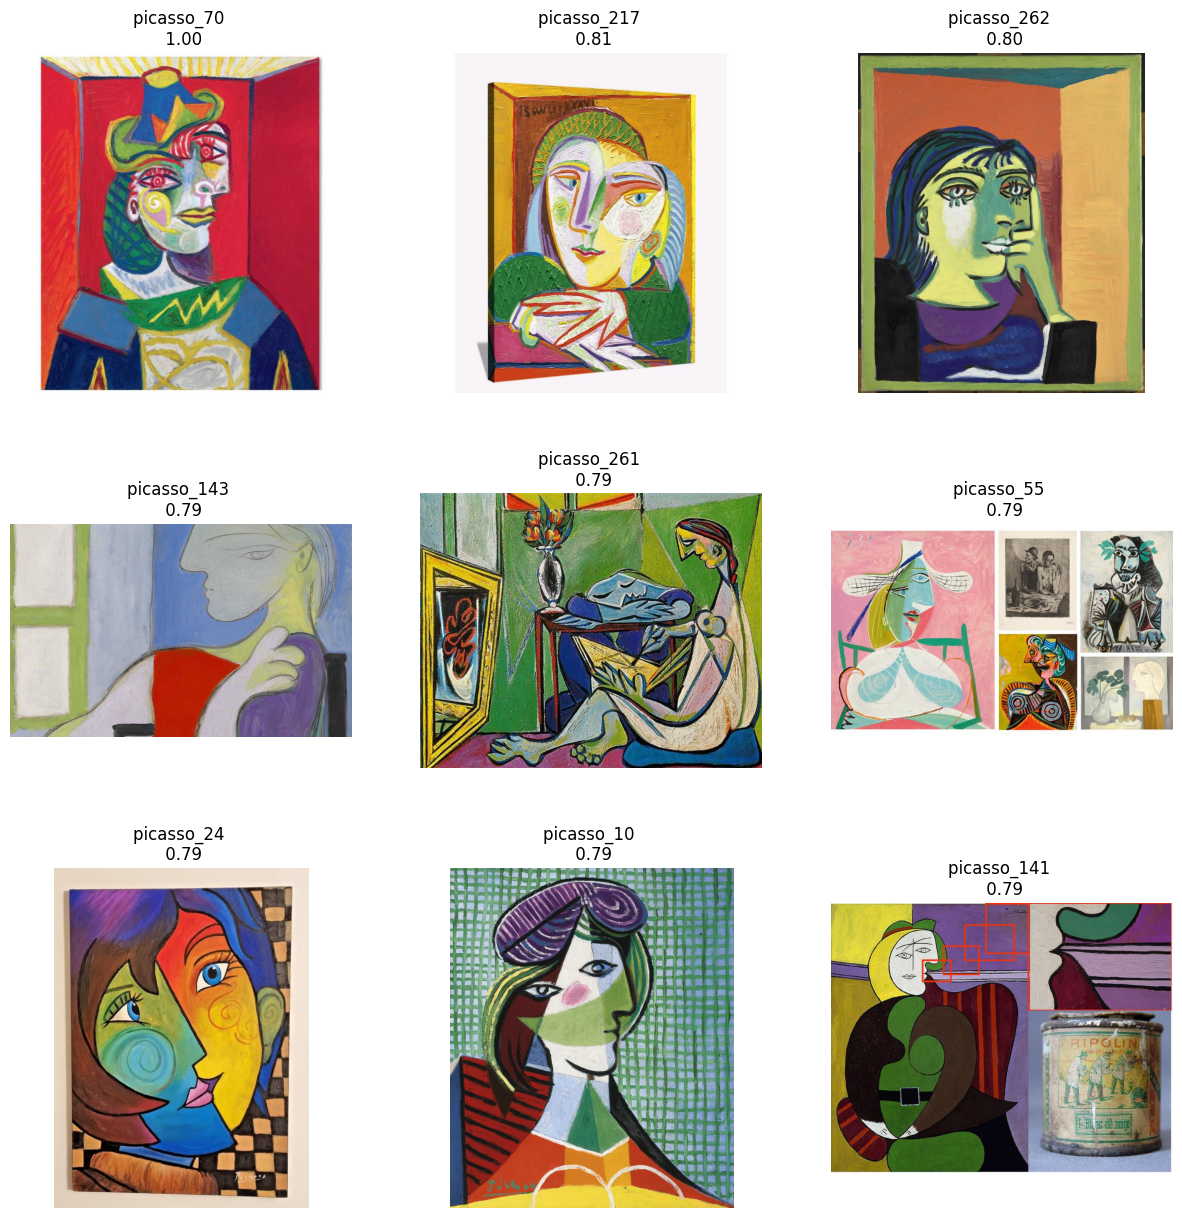

In [47]:
# @title {run:'auto'}

slider_value = 60  # @param {type: "slider", min: 0, max: 382}
plot_neighborhood(neighborhoods_dict[list(neighborhoods_dict.keys())[slider_value]])


In [58]:
my_path

PosixPath('/gdrive/MyDrive/art_recommendation/picasso_2')

In [84]:
path = Path('/gdrive/MyDrive/art_recommendation')
other_path = path / 'Junjo Ito'

with open(other_path / 'paintings_embeddings.pickle', 'rb') as handle:
    other_paintings_dictionary = pickle.load(handle)

combined_dictionary = {**paintings_embeddings, **other_paintings_dictionary }
combined_dictionary.keys()

# separate vectors and images (for convenience)
X = []
images = []
for image, embedding in combined_dictionary.items():
    X.append(embedding)
    images.append(str(image))


# sklearn gives the cosine distance = 1 - cos_similarity
nbrs = NearestNeighbors(n_neighbors=9, metric='cosine').fit(X)
neighbor_distances, neighbor_indices = nbrs.kneighbors(X)
nbrs

NearestNeighbors(metric='cosine', n_neighbors=9)

In [86]:
neighbor_similarities = 1 - neighbor_distances
neighborhoods_dict_2 = {}
for i in range(len(neighbor_indices)):
    center_image = images[neighbor_indices[i, 0]]
    neighbors_list = [];
    for j in range(0, len(neighbor_indices[0])):
        neighbor_image = images[neighbor_indices[i][j]]
        neighbor_similarity =  neighbor_similarities[i][j]
        neighbors_list.append([neighbor_image, neighbor_similarity])
    neighborhoods_dict_2[center_image] = neighbors_list
neighborhoods_dict_2['art_recommendation/Junjo Ito/paintings/image_259.jpg']

[['art_recommendation/Junjo Ito/paintings/image_259.jpg', 1.0],
 ['art_recommendation/Junjo Ito/paintings/image_242.jpg', 0.825665],
 ['art_recommendation/Junjo Ito/paintings/image_121.jpg', 0.77338475],
 ['art_recommendation/Junjo Ito/paintings/image_599.jpg', 0.76705897],
 ['art_recommendation/Junjo Ito/paintings/image_680.jpg', 0.76033735],
 ['art_recommendation/Junjo Ito/paintings/image_694.jpg', 0.7541293],
 ['art_recommendation/Junjo Ito/paintings/image_98.jpg', 0.75081015],
 ['art_recommendation/Junjo Ito/paintings/image_129.jpg', 0.74014497],
 ['art_recommendation/Junjo Ito/paintings/image_524.jpg', 0.7356812]]

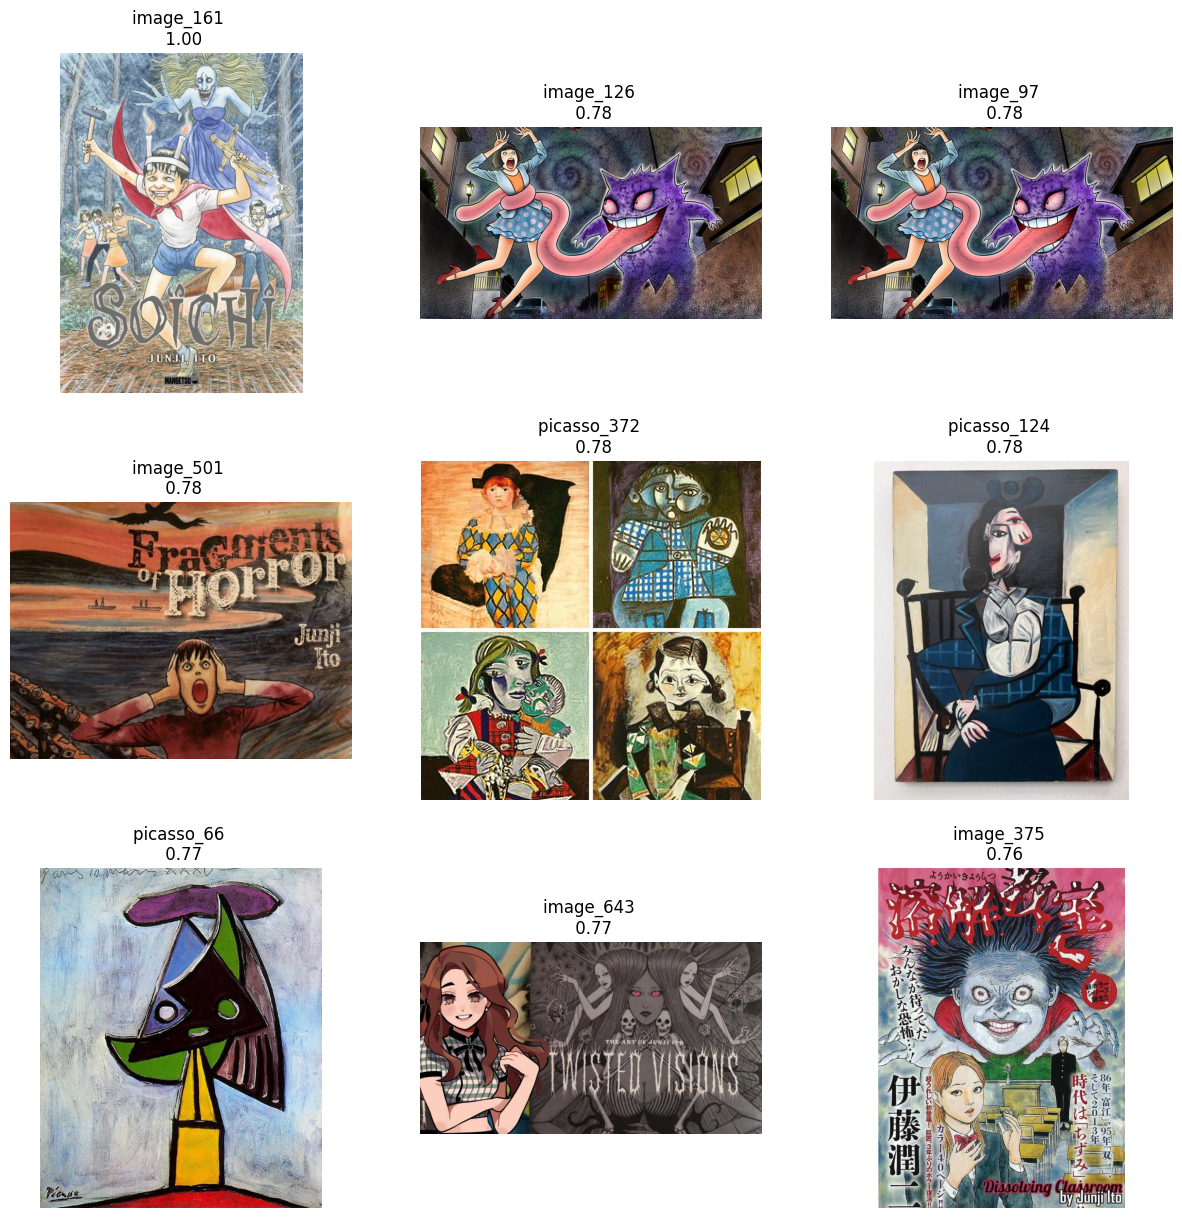

In [88]:
# @title {run:'auto'}

slider_value = 441  # @param {type: "slider", min: 0, max: 905}
plot_neighborhood(neighborhoods_dict_2[list(neighborhoods_dict_2.keys())[slider_value]])


In [89]:
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.0 MB/s eta 0:00:00


In [92]:
from sklearn_extra.cluster import KMedoids

# We want to create the model with 37 clusters,
# dividing vectors using the cosine similarity metric
# and using the k-medoids++ initialization algorithm
# we want to define a random_state to make our result reproducible


kmedoids = KMedoids(n_clusters=37, random_state=0,
                        init='k-medoids++', metric='cosine').fit(X)


#assignment of images to different clusters
image_clusters = dict(zip(images, kmedoids.labels_))

clusters, counts = np.unique(kmedoids.labels_, return_counts=True)

cluster_counts = sorted(list(zip(clusters, counts)), key=lambda x:x[-1], reverse=True)
cluster_counts = dict(cluster_counts)
cluster_counts

{29: 87,
 31: 54,
 14: 42,
 13: 40,
 2: 38,
 8: 37,
 3: 36,
 22: 33,
 9: 31,
 21: 31,
 0: 28,
 25: 26,
 7: 25,
 36: 25,
 27: 24,
 1: 23,
 20: 23,
 12: 22,
 24: 22,
 28: 21,
 10: 19,
 23: 19,
 4: 17,
 6: 16,
 11: 16,
 5: 15,
 16: 15,
 19: 15,
 30: 12,
 18: 11,
 33: 11,
 35: 11,
 15: 10,
 26: 10,
 32: 7,
 17: 5,
 34: 3}

In [93]:
representative_images = []
representative_embeddings = []
cluster_number_repr_images = []
for image, embedding in combined_dictionary.items():

    for cluster_number, repr_embedding in enumerate(kmedoids.cluster_centers_):
        comparison = np.equal(repr_embedding, embedding)
        if comparison.all():
            representative_images.append(image)
            representative_embeddings.append(embedding)
            cluster_number_repr_images.append(cluster_number)

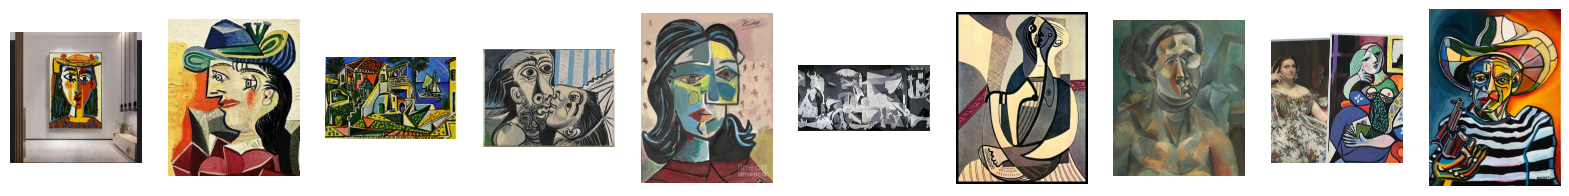

In [94]:
f, axarr = plt.subplots(1, 10, figsize=(20, 20))

for i in range(10):
  axarr[i].imshow(io.imread(my_path.parent.parent / representative_images[i]))
  axarr[i].axis('off')

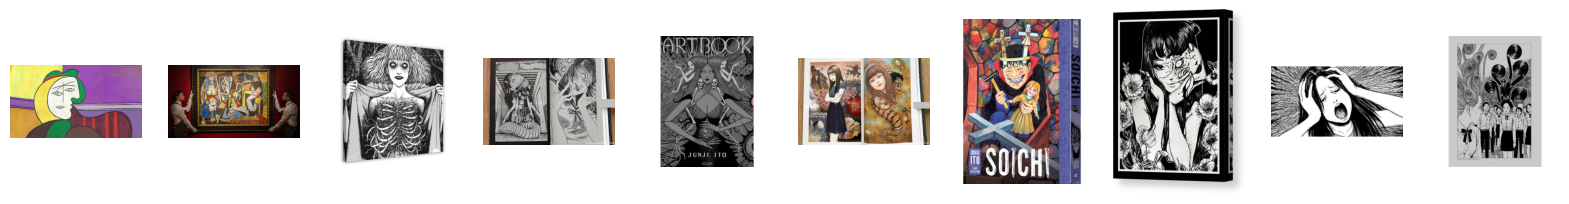

In [97]:
f, axarr = plt.subplots(1, 10, figsize=(20, 20))

for i in range(10):
  axarr[i].imshow(io.imread(my_path.parent.parent / representative_images[10+i]))
  axarr[i].axis('off')

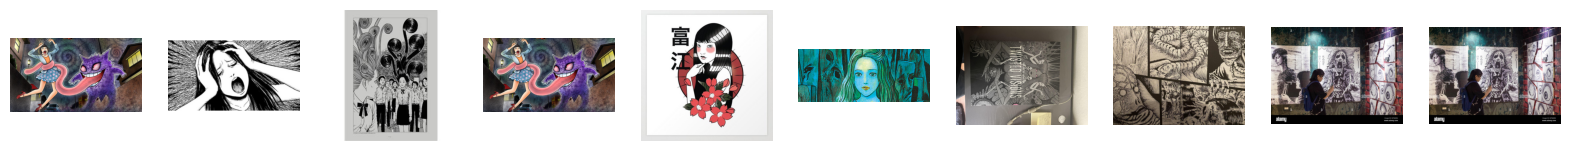

In [98]:
f, axarr = plt.subplots(1, 10, figsize=(20, 20))

for i in range(10):
  axarr[i].imshow(io.imread(my_path.parent.parent / representative_images[20+i]))
  axarr[i].axis('off')